# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wsl wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

In [2]:
mat = loadmat('MR_data.mat')

In [3]:
noisefree = mat['I_noisefree']
noisy1 = mat['I_noisy1']
noisy2 = mat['I_noisy2']
noisy3 = mat['I_noisy3']
noisy4 = mat['I_noisy4']

In [4]:
def plot_img(img, cmap='gray', title=''):
    plt.figure(figsize=(img.shape[0]/30,img.shape[1]/30))
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [5]:
def plot_convolution(img, dst,
                     show_orig=True, show_dst=True, show_diff=True):
    cols = show_orig + show_dst + show_diff

    fig, axs = plt.subplots(ncols=cols, figsize=(cols * 5, 5))
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    if show_orig: 
        index = 0
        axs[index].imshow(img, cmap='gray', vmin=0, vmax=255)
        axs[index].set_title('Original image')

    if show_dst:
        index = int(show_orig)
        axs[index].imshow(dst, cmap='gray', vmin=0, vmax=255)
        axs[index].set_title('Processed image')

    if show_diff:
        index = int(show_orig + show_dst)

        df = dst.astype(np.int32) - img.astype(np.int32)
        max_val = np.max(np.abs(df))
        df[0, 0] = max_val
        df[-1, -1] = -max_val

        axs[index].imshow(df, cmap='coolwarm')
        axs[index].set_title('Difference')

    plt.show()

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [6]:
from itertools import product
from scipy.stats import norm

In [7]:
def gaussian_window(window_size=5, sigma=1.5):
    def distance(x, y, i, j):
        return np.linalg.norm([x - i, y - j])
    
    def gauss(v):
        return norm.pdf(v, loc=0, scale=sigma)
    
    window = np.zeros((window_size, window_size))
    x, y = window_size // 2, window_size // 2
    
    for i, j in product(range(window_size), range(window_size)):
        dist = distance(x, y, i, j)
        window[i, j] = gauss(dist)
        
    Wn = np.sum(window)
    
    return window / Wn

In [8]:
def convolution(img, window=gaussian_window()):
    window_size = window.shape[0] // 2
    
    assert window.shape[0] % 2 == 1, 'window size must be an odd number'
    
    convoluted = np.copy(img)
    for i in range(window_size, img.shape[0]-window_size):
        for j in range(window_size, img.shape[1]-window_size):
            convoluted[i, j] = np.sum(
                img[i-window_size:i+window_size+1, j-window_size:j+window_size+1] * window
            )
        
    return convoluted.astype(np.uint8)

In [9]:
gaussian_window()

array([[0.01441882, 0.02808402, 0.0350727 , 0.02808402, 0.01441882],
       [0.02808402, 0.05470021, 0.06831229, 0.05470021, 0.02808402],
       [0.0350727 , 0.06831229, 0.08531173, 0.06831229, 0.0350727 ],
       [0.02808402, 0.05470021, 0.06831229, 0.05470021, 0.02808402],
       [0.01441882, 0.02808402, 0.0350727 , 0.02808402, 0.01441882]])

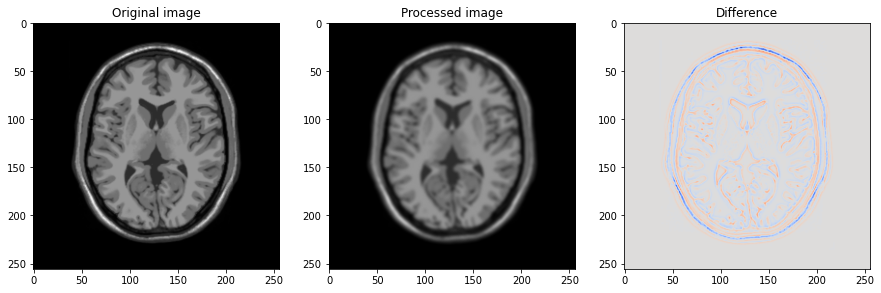

In [10]:
dst = convolution(noisefree)
plot_convolution(noisefree, dst)

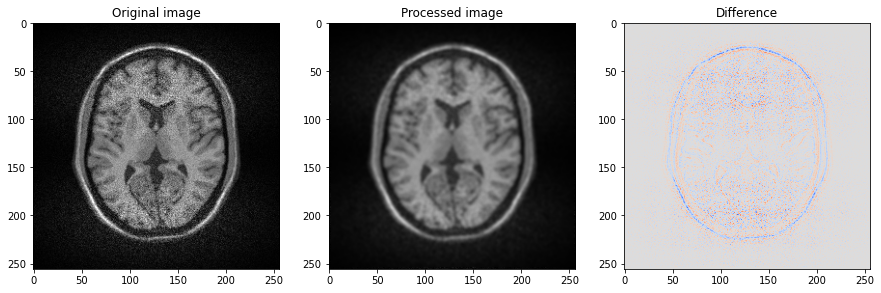

In [11]:
dst = convolution(noisy2)
plot_convolution(noisy2, dst)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [12]:
def bilateral_convolution(img, window=gaussian_window(), sigma_r=15.0):
    window_size = window.shape[0] // 2
    
    assert window.shape[0] % 2 == 1, 'window size must be an odd number'

    def gamma(v):
        v = np.int64(v)
        return np.exp(- (v * v) / (2 * sigma_r * sigma_r))
    
    def local_weighing(image_window, v):
        lwindow = np.copy(window)
        for x in range(window_size):
            for y in range(window_size):
                lwindow[x, y] = lwindow[x, y] * gamma(v - image_window[x, y])
        return np.sum(lwindow * image_window) / np.sum(lwindow)
    
    convoluted = np.copy(img)
    for i in range(window_size, img.shape[0]-window_size):
        for j in range(window_size, img.shape[1]-window_size):
            image_window = img[i-window_size:i+window_size+1, j-window_size:j+window_size+1]
            convoluted[i, j] = local_weighing(image_window, img[i, j])
        
    return convoluted.astype(np.uint8)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


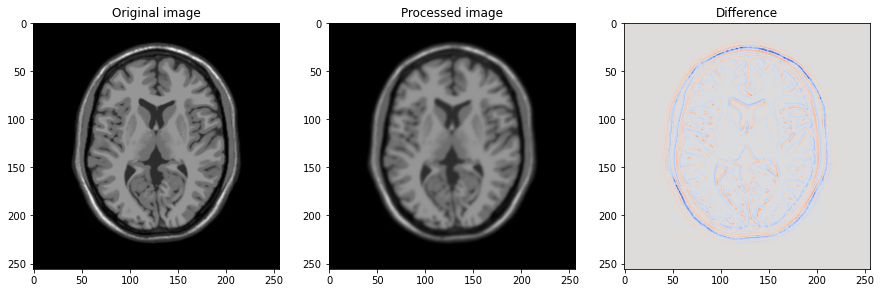

In [13]:
dst = bilateral_convolution(noisefree)
plot_convolution(noisefree, dst)

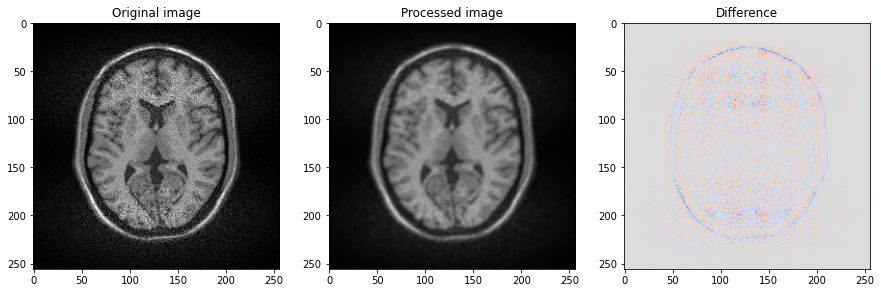

In [14]:
dst = bilateral_convolution(noisy2)
plot_convolution(noisy2, dst)

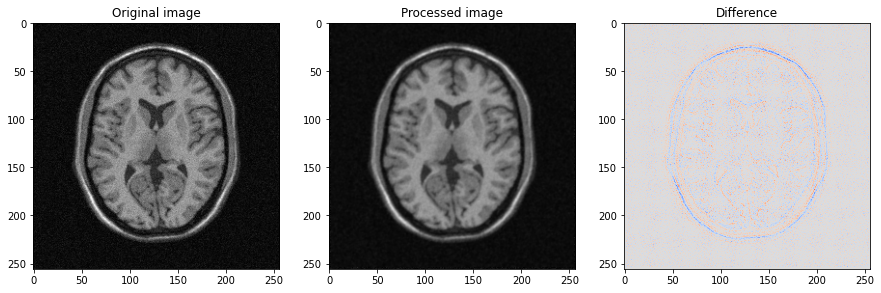

In [15]:
dst = bilateral_convolution(noisy1, gaussian_window(sigma=0.8))
plot_convolution(noisy1, dst)

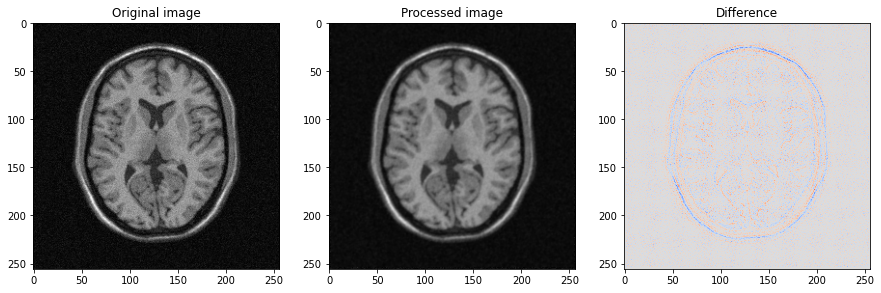

In [16]:
dst2 = convolution(noisy1, gaussian_window(sigma=0.8))
plot_convolution(noisy1, dst)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


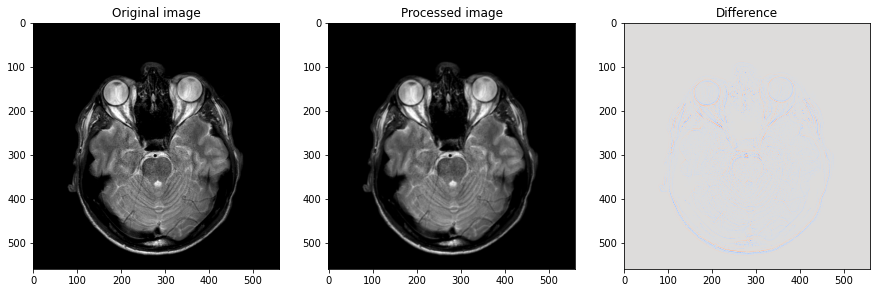

In [17]:
dst = bilateral_convolution(noisy3, gaussian_window(sigma=0.8))
plot_convolution(noisy3, dst)

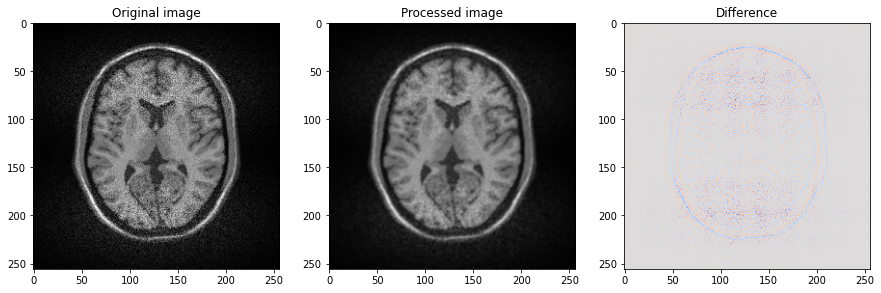

In [18]:
dst = bilateral_convolution(noisy2, gaussian_window(sigma=0.8))
plot_convolution(noisy2, dst)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


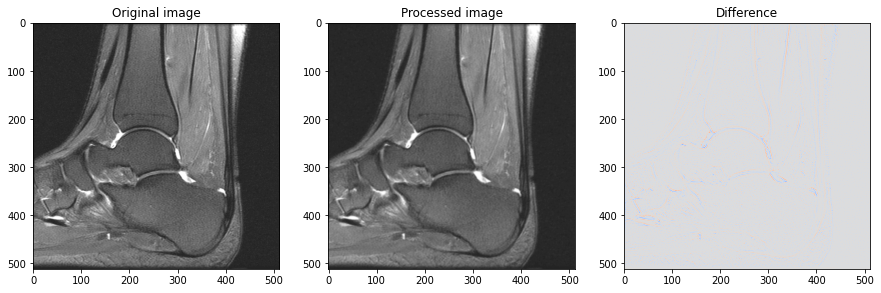

In [19]:
dst = bilateral_convolution(noisy4, gaussian_window(sigma=0.8))
plot_convolution(noisy4, dst)

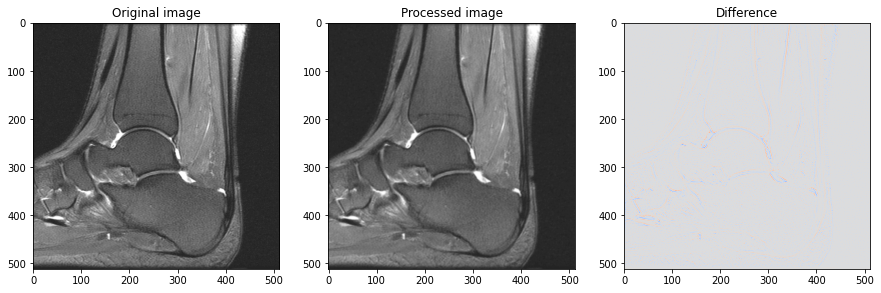

In [20]:
dst2 = convolution(noisy4, gaussian_window(sigma=0.8))
plot_convolution(noisy4, dst)

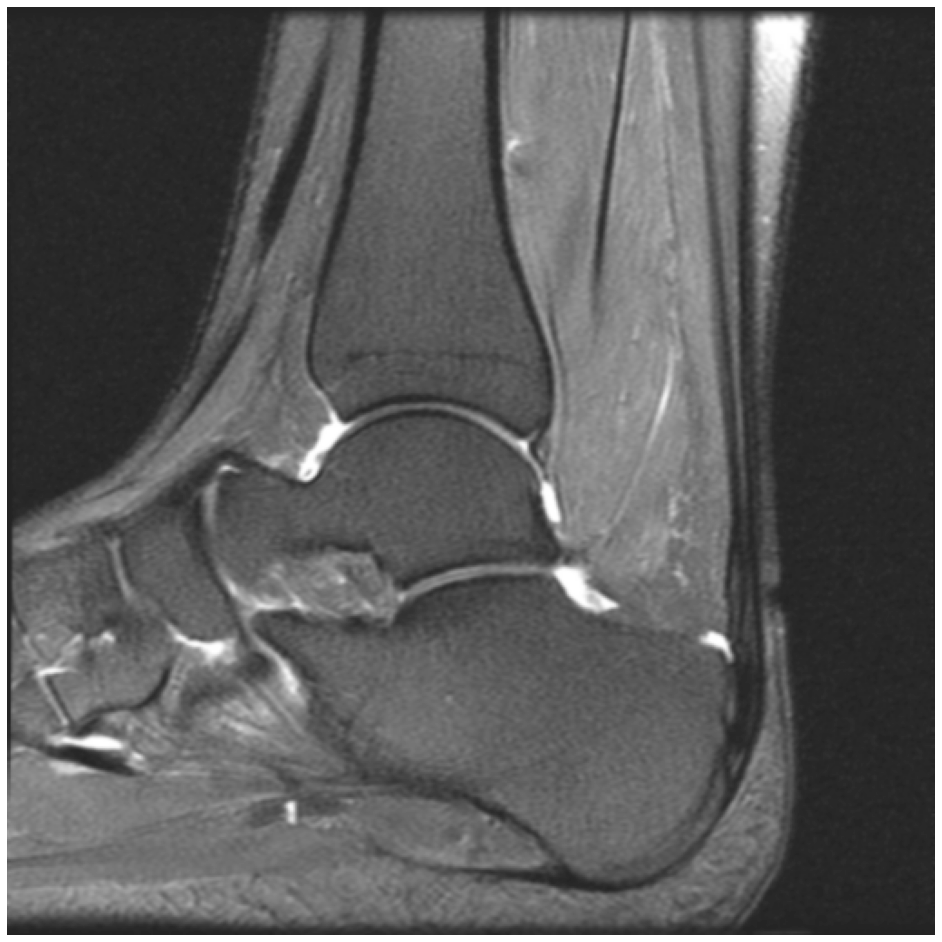

In [21]:
plot_img(dst)

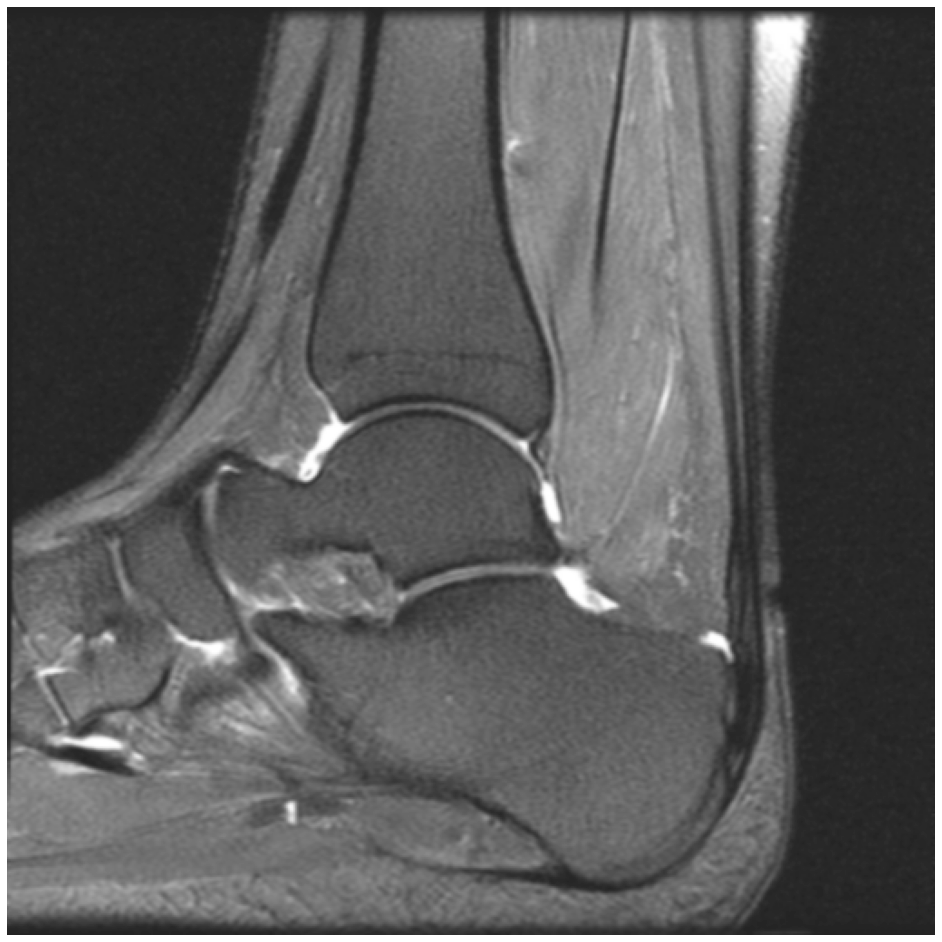

In [22]:
plot_img(dst2)